# Install Requirements

In [1]:
!pip -qq install transformers
!pip -qq install datasets
!pip -qq  install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.7 MB/s eta 0:00:00


In [2]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, log_loss
from tqdm.auto import tqdm
import random


import datasets
from datasets import load_dataset
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    T5ForConditionalGeneration,
    T5Tokenizer,
)



In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Load and Explore Dataset

In [4]:
# Load dataset train and val

dataset = load_dataset("tasksource/bigbench", "sports_understanding")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for tasksource/bigbench contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tasksource/bigbench
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [5]:
# Load dataset test
dataset_test = load_dataset("lukaemon/bbh", "sports_understanding")

Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['inputs', 'targets', 'multiple_choice_targets', 'multiple_choice_scores', 'idx'],
        num_rows: 789
    })
    validation: Dataset({
        features: ['inputs', 'targets', 'multiple_choice_targets', 'multiple_choice_scores', 'idx'],
        num_rows: 197
    })
})

In [7]:
dataset["train"][0]

{'inputs': 'Determine whether the following statement or statements are plausible or implausible:\nStatement: Trevor Bauer swung to protect the runner in the World Series\nPlausible/implausible?',
 'targets': ['plausible'],
 'multiple_choice_targets': ['plausible', 'implausible'],
 'multiple_choice_scores': [1, 0],
 'idx': 0}

In [8]:
dataset_test

DatasetDict({
    test: Dataset({
        features: ['input', 'target'],
        num_rows: 250
    })
})

In [9]:
dataset_test["test"][0]

{'input': 'Is the following sentence plausible? "Elias Lindholm beat the buzzer."',
 'target': 'no'}

# Load Model

In [10]:
# Load Model and Tokenizer

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# Answer Only Prompt

  0%|          | 0/250 [00:00<?, ?it/s]

Accuracy: 0.588


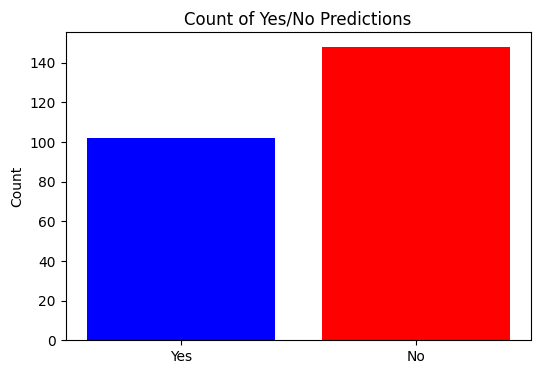

In [ ]:
def predict_yes_no(dataset_test):
    predictions = []

    for i in tqdm(range(len(dataset_test["test"]))):
        # Extract the input question
        question = dataset_test["test"][i]['input']
        # Structuring the prompt more explicitly
        formatted_input = f"Given the statement: {question} Is the statement true or false? Provide 'yes' for true and 'no' for false."

        # Tokenize and generate prediction
        inputs = tokenizer(formatted_input, return_tensors="pt", padding=True, truncation=True, max_length=512)
        outputs = model.generate(inputs['input_ids'], max_length=128)
        raw_prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Post-process to get a yes/no answer
        prediction = "yes" if "yes" in raw_prediction.lower() else "no"
        predictions.append(prediction)

    # Actual labels
    actual_labels = [dataset_test["test"][i]['target'] for i in range(len(dataset_test["test"]))]

    # Save predictions and actual targets to a CSV file
    results_df = pd.DataFrame({'Input': [dataset_test["test"][i]['input'] for i in range(len(dataset_test["test"]))],
                               'Actual Target': actual_labels,
                               'Predicted': predictions})
    results_df.to_csv('model_predictions_yes_no.csv', index=False)

    # Calculate accuracy
    accuracy = accuracy_score(actual_labels, predictions)
    print(f"Accuracy: {accuracy}")

    # Count the occurrences of 'yes' and 'no'
    yes_count = predictions.count('yes')
    no_count = predictions.count('no')

    # Create a bar plot for the counts of 'yes' and 'no' predictions
    plt.figure(figsize=(6, 4))
    plt.bar(['Yes', 'No'], [yes_count, no_count], color=['blue', 'red'])
    plt.ylabel('Count')
    plt.title('Count of Yes/No Predictions')
    plt.show()

    return results_df, accuracy

# Call the function with your dataset
results_df, accuracy = predict_yes_no(dataset_test)


# 3 shot - Train Prompt

  0%|          | 0/250 [00:00<?, ?it/s]

Raw prediction example 1: yes
Raw prediction example 2: yes
Raw prediction example 3: yes
Accuracy (excluding ambiguous cases): 0.564


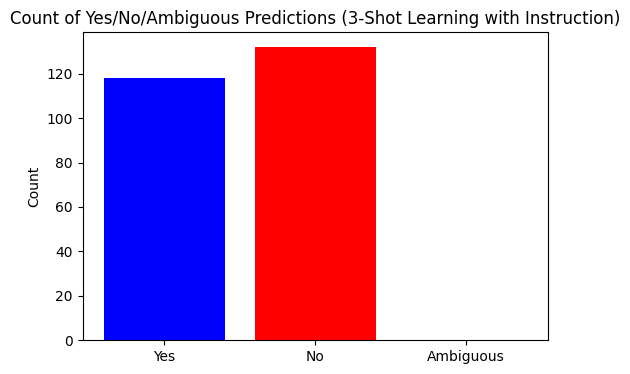

In [ ]:
def predict_yes_no_3_shot_mapped_with_instruction(dataset_train, dataset_test):
    predictions = []
    raw_predictions = []  # Store raw predictions for inspection

    # Select three random examples from the training set
    example_indices = random.sample(range(len(dataset_train["train"])), 3)
    examples = [dataset_train["train"][i] for i in example_indices]

    for i in tqdm(range(len(dataset_test["test"]))):
        # Construct the 3-shot prompt with examples
        prompt = ""
        for example in examples:
            statement = example['inputs'].replace('\n', ' ')
            answer = "yes" if example['multiple_choice_targets'][example['multiple_choice_scores'].index(1)] == 'plausible' else "no"
            prompt += f"Statement: {statement} Answer with 'yes' or 'no': {answer}\n"

        # Add the current test question to the prompt with instruction to answer with 'yes' or 'no'
        question = dataset_test["test"][i]['input']
        prompt += f"Statement: {question} Answer with 'yes' or 'no':"

        # Tokenize and generate prediction
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512)
        outputs = model.generate(inputs['input_ids'], max_length=128)
        raw_prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        raw_predictions.append(raw_prediction)  # Store the raw prediction

        # Post-process to get a yes/no answer
        if "yes" in raw_prediction.lower() and "no" not in raw_prediction.lower():
            prediction = "yes"
        elif "no" in raw_prediction.lower() and "yes" not in raw_prediction.lower():
            prediction = "no"
        else:
            # If both or neither are present, or if it's ambiguous, you might need a more sophisticated method
            prediction = "ambiguous"
        predictions.append(prediction)

    # Check some raw predictions
    for i in range(3):
        print(f"Raw prediction example {i+1}: {raw_predictions[i]}")

    # Actual labels
    actual_labels = [dataset_test["test"][i]['target'] for i in range(len(dataset_test["test"]))]

    # Save predictions and actual targets to a CSV file
    results_df = pd.DataFrame({'Input': [dataset_test["test"][i]['input'] for i in range(len(dataset_test["test"]))],
                               'Actual Target': actual_labels,
                               'Predicted': predictions})
    results_df.to_csv('model_predictions_yes_no_3_shot_mapped_with_instruction.csv', index=False)

    # Calculate accuracy (excluding ambiguous cases)
    accurate_predictions = [pred for pred, actual in zip(predictions, actual_labels) if pred != "ambiguous"]
    accurate_labels = [actual for pred, actual in zip(predictions, actual_labels) if pred != "ambiguous"]
    accuracy = accuracy_score(accurate_labels, accurate_predictions) if accurate_predictions else 0
    print(f"Accuracy (excluding ambiguous cases): {accuracy}")

    # Count the occurrences of 'yes', 'no', and 'ambiguous'
    yes_count = predictions.count('yes')
    no_count = predictions.count('no')
    ambiguous_count = predictions.count('ambiguous')

    # Create a bar plot for the counts of 'yes', 'no', and 'ambiguous' predictions
    plt.figure(figsize=(6, 4))
    plt.bar(['Yes', 'No', 'Ambiguous'], [yes_count, no_count, ambiguous_count], color=['blue', 'red', 'grey'])
    plt.ylabel('Count')
    plt.title('Count of Yes/No/Ambiguous Predictions (3-Shot Learning with Instruction)')
    plt.show()

    return results_df, accuracy

# Call the function with your dataset
results_df_3_shot_mapped_with_instruction, accuracy_3_shot_mapped_with_instruction = predict_yes_no_3_shot_mapped_with_instruction(dataset, dataset_test)


# COT

  0%|          | 0/250 [00:00<?, ?it/s]

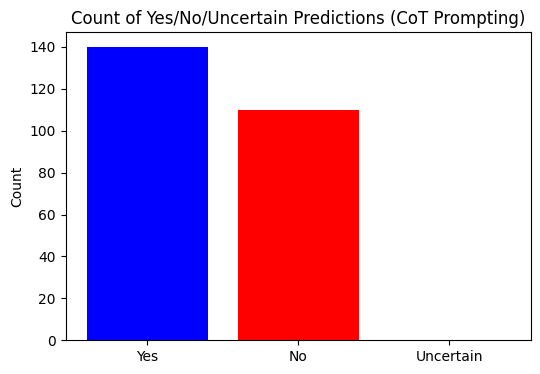

Accuracy: 0.508


In [14]:
def extract_yes_no(answer):
    # Define patterns that typically indicate a yes or no answer
    yes_pattern = re.compile(r"\b(yes|yeah|sure|correct|indeed|right|true)\b", re.IGNORECASE)
    no_pattern = re.compile(r"\b(no|nah|nope|false|incorrect|wrong|not)\b", re.IGNORECASE)

    # Check for 'yes' or 'no' in the answer
    if yes_pattern.search(answer):
        return "yes"
    elif no_pattern.search(answer):
        return "no"
    else:
        return "uncertain"  # or any default value you prefer

def predict_with_cot(dataset_test):
    predictions = []
    max_length_output = 512  # Adjust as needed, but keep within the model's limits

    for question in tqdm(dataset_test["test"]):
        cot_input = f"Answer the following yes/no question by reasoning step-by-step: {question['input']}"
        inputs = tokenizer(cot_input, return_tensors="pt", padding=True, truncation=True, max_length=512)

        # Generate the output with a specified maximum length
        outputs = model.generate(inputs['input_ids'], max_length=max_length_output)

        raw_prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract yes/no from the prediction
        yes_no_prediction = extract_yes_no(raw_prediction)
        predictions.append(yes_no_prediction)

    # Actual labels
    actual_labels = [item['target'] for item in dataset_test["test"]]

    # Calculate accuracy
    accuracy = accuracy_score(actual_labels, predictions)

    # Save predictions and actual targets to a CSV file
    results_df = pd.DataFrame({'Input': [item['input'] for item in dataset_test["test"]],
                               'Actual Target': actual_labels,
                               'Predicted': predictions})
    results_df.to_csv('model_predictions_cot.csv', index=False)

    # Count the occurrences of 'yes', 'no', and 'uncertain'
    yes_count = predictions.count('yes')
    no_count = predictions.count('no')
    uncertain_count = predictions.count('uncertain')

    # Create a bar plot for the counts of 'yes', 'no', and 'uncertain' predictions
    plt.figure(figsize=(6, 4))
    plt.bar(['Yes', 'No', 'Uncertain'], [yes_count, no_count, uncertain_count], color=['blue', 'red', 'grey'])
    plt.ylabel('Count')
    plt.title('Count of Yes/No/Uncertain Predictions (CoT Prompting)')
    plt.show()

    return results_df, accuracy

# Call the function with your dataset
results_df_cot, accuracy_cot = predict_with_cot(dataset_test)
print(f"Accuracy: {accuracy_cot}")